# SARS/COVID epitope prediction (TASK 1)
<b>Author</b>: GHEZAIEL Morad<br>
<b>Age</b>: 25 <br>
<b>Education</b>: M.sc 1 Immunology, M.sc 2 Bioinformatics<br>
<b>Mail</b>: ghezaiel.morad@gmail.com<br>
<b>Phone</b>: +336.40.46.58.77<br>
<b>Location</b>: Nice, FRANCE<br>
<b>Date</b>: 08/02/20<br>

## Introduction:
<b>In</b> this notebook, we will take advantage of the B-cells epitope dataset provided by Future Corporation with the aim to predict antibody binding activity.<br>
<b>Especially</b>, we aim to find an experimental setup (model design) that will fit this activity prediction problem.<br>
<b>This</b> first task is about trying to predict sars specific epitope binding activity using homologous data from the IEDB and Uniprot databases.<br> 

<i>Depending on the results, we will use the same architecture for the second task (trying to predict Covid specific epitope binding activity).</i>



# Library loading

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import re 
from keras.utils import plot_model
from keras.layers.merge import concatenate
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import auc
import keras 
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.models import Model 
import tensorflow as tf 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/epitope-prediction/input_sars.csv
/kaggle/input/epitope-prediction/input_bcell.csv
/kaggle/input/epitope-prediction/input_covid.csv


# Data loading

In [20]:
train = pd.read_csv("/kaggle/input/epitope-prediction/input_bcell.csv")
test = pd.read_csv("/kaggle/input/epitope-prediction/input_sars.csv")
pred = pd.read_csv("/kaggle/input/epitope-prediction/input_covid.csv")

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
pred.head()

# Feature description

In [ ]:
plt.style.use("ggplot")
ax = train.hist(figsize=(15,15))
plt.suptitle("IEDB/Uniprot Igs",fontsize=30)

In [ ]:
ax = test.hist(figsize=(15,15))
plt.suptitle("Sars Igs",fontsize=30)

In [ ]:
concatenated = pd.concat([train.filter([i for i in train.columns if i !="target"]),test])
ax = concatenated.hist(figsize=(15,15))
plt.suptitle("Covid Igs",fontsize=30)

In [ ]:
pd.DataFrame({"B-cells protein length": [len(i) for i in train["protein_seq"]],
              "B-cells peptide length":[len(i) for i in train["peptide_seq"]]}).hist(figsize=(10,5))
pd.DataFrame({"Sars protein length":[len(i) for i in test["protein_seq"]],
             "Sars peptide length":[len(i) for i in test["peptide_seq"]]}).hist(figsize=(10,5))
pd.DataFrame({"Covid protein length":[len(i) for i in pred["protein_seq"]],
             "Covid peptide length":[len(i) for i in pred["peptide_seq"]]}).hist(figsize=(10,5))

# Feature engineering

In [23]:
## Log transformation for continuous and zero inflated features
def logTransform(df,colname): 
    # Log transofrm
    df["{}_log".format(colname)]= np.log(df[colname]+1)
    
    return df 

## Add bins to features of interest
def addBins(df):
    # The function is about labeling peptids according to feature specific thresholds.
    aro_bin = []
    for i in df["aromaticity"]: 
        if i<=0.05: 
            aro_bin+=[0]
        elif i>0.05 and i<=0.1: 
            aro_bin+=[1]
        else: 
            aro_bin+=[2]
    hydro_bin = []
    for i in df["hydrophobicity"]: 
        if i<=-0.75: 
            hydro_bin+=[0]
        elif i >0.75 and i<=0: 
            hydro_bin+=[1]
        else:
            hydro_bin+=[2]
    stab_bin = []
    for i in df["stability"]: 
        if i<=13: 
            stab_bin+=[0]
        elif i>13 and i<=+60: 
            stab_bin+=[1]
        else: 
            stab_bin+=[2]
    iso_bin = []
    for i in df["isoelectric_point"]: 
        if i<=7.45: 
            iso_bin+=[0]
        else: 
            iso_bin+=[1]
    parker_bin = []
    for i in df["parker"]: 
        if i<=0: 
            parker_bin+=[0]
        elif i>0 and i<=3: 
            parker_bin+=[1]
        else: 
            parker_bin+=[2]
    
    kt_bin = []
    for i in df["kolaskar_tongaonkar"]: 
        if i<=0.95: 
            kt_bin+=[0]
        elif i>0.95 and i<=1.08: 
            kt_bin+=[1]
        else: 
            kt_bin+=[2]
    cf_bin = []
    for i in df["chou_fasman"]: 
        if i<=0.84: 
            cf_bin+=[0]
        elif i>0.84 and i<=1.12: 
            cf_bin+=[1]
        else: 
            cf_bin+=[2]
            
    # Add the resulting feature to the dataframe
    df["aro_bin"]=aro_bin
    df["hydro_bin"]=hydro_bin
    df["stab_bin"]=stab_bin
    df["iso_bin"]=iso_bin 
    df["parker_bin"]=parker_bin 
    df["kt_bin"]=kt_bin 
    df['cf_bin']=cf_bin
    
    return df 
    

## Add amino acids frequencies (absolute and length normalized frequencies)
def addAminoAcidsFrequencies(df,level):
    # Add sequence length as features
    df["protein_length"],df["peptide_length"] = [len(i) for i in df["protein_seq"]], [len(i) for i in df["peptide_seq"]]
    
    # Create an indexed amino acid dictionnary
    base = {"A":1,"R":16,"N":13,"D":18,"C":3,"E":19,"Q":14,"G":0,"H":17,"I":6,"L":5,
                     "K":15,"M":7,"F":9,"P":4,"S":10,"T":11,"W":8,"Y":12,"V":2}
    
    # Placeholders
    aa_freqs,norm_freqs = [],[]
    
    # Compute frequencies
    for _seq in df[level]: 
        seq = [i for i in _seq] 
        freq,norm_freq = [seq.count(aa) for aa in base],[seq.count(aa)/len(seq) for aa in base]
        aa_freqs.append(freq)
        norm_freqs.append(norm_freq)
    aa_freqs, norm_freqs = np.array(aa_freqs), np.array(norm_freqs)
    
    # Concat the results with the dataframe
    df = pd.concat([df,pd.DataFrame(aa_freqs,columns = ["{}_freq_{}".format(i,level) for i in base]),
                    pd.DataFrame(norm_freqs,columns = ["{}_norm_freq_{}".format(i,level) for i in base])],
                    axis=1, join='inner')
    
    return df 

## Add biochemical feature to the dataframe
def addBcmFeatures(df,level): 
    # Define the AA dictionnary
    base = {"A":1,"R":16,"N":13,"D":18,"C":3,"E":19,"Q":14,"G":0,"H":17,"I":6,"L":5,
                     "K":15,"M":7,"F":9,"P":4,"S":10,"T":11,"W":8,"Y":12,"V":2}
    
    # And placeholders for a bunch of amino acids related biochemical features
    p_charge,n_charge,charge,branched,beta_branched, polar,polar_uncharged,apolar,aromatic, thiol, hydroxy, struct = [],[],[],[],[],[],[],[],[],[],[],[]
    for _seq in df[level]: 
        seq = [i for i in _seq] 
        _p_charge,_n_charge = sum([1 if aa in ["R","K","H"] else 0 for aa in seq]),sum([1 if aa in ["D","E"] else 0 for aa in seq])
        _aromatic = sum([1 if aa in ["F","W","Y"] else 0 for aa in seq])
        _branched, _beta_branched = sum([1 if aa in ["L","I","V"] else 0 for aa in seq]), sum([1 if aa in ["T","V","I"] else 0 for aa in seq])
        _polar,_polar_uncharged = sum([1 if aa in ["S","T","N","Q","R","H","K","D","E"] else 0 for aa in seq]), sum([1 if aa in ["S","T","N","Q"] else 0 for aa in seq])
        _apolar, _thiol = sum([1 if aa in ["A","V","I","L","M","F","Y","W"] else 0 for aa in seq]),sum([1 if aa in ["M","C"] else 0 for aa in seq]),                                
        _hydroxy,_struct = sum([1 if aa in ["S","T","Y"] else 0 for aa in seq]),sum([1 if aa in ["G","P"] else 0 for aa in seq])
                    
        p_charge.append(_p_charge)
        n_charge.append(_n_charge)
        aromatic.append(_aromatic)
        branched.append(_branched)
        beta_branched.append(_beta_branched)
        polar.append(_polar)
        polar_uncharged.append(_polar_uncharged)
        apolar.append(_apolar)
        thiol.append(_thiol)
        hydroxy.append(_hydroxy)
        struct.append(_struct)
    
    # Add the resulting feature to the dataframe
    df["p_charge_{}".format(level)]=p_charge
    df["n_charge_{}".format(level)]=n_charge
    df["aromatic_{}".format(level)]=aromatic
    df["branched_{}".format(level)]=branched
    df["beta_branched_{}".format(level)]=beta_branched
    df["polar_{}".format(level)]=polar
    df["polar_uncharged_{}".format(level)]=polar_uncharged
    df["apolar_{}".format(level)]=apolar
    df["thiol_{}".format(level)]=thiol
    df["hydroxy_{}".format(level)]=hydroxy
    df["struct_{}".format(level)]=struct
    
    return df 

## Add glycosylation related features to the dataframe
def addPTMFeatures(df,level):
    N_glyco,N_glyco_dists = [],[]
    for _seq in df[level]: 
        _N = len(re.findall("N[^P][ST]",_seq))
        if _N>0:
            positions = [i.start() for i in re.finditer("[N[^P][ST]",_seq)]
            proximity = np.mean([abs(x-y) for x in positions for y in positions if x!=y if x==x if y==y])
            if proximity!=proximity: 
                proximity = 0
        else: 
            proximity = 0
       
        N_glyco.append(_N)
        N_glyco_dists.append(proximity)
    print(len(N_glyco),len(N_glyco_dists))
    df["N_glyco_{}".format(level)]=N_glyco
    df["N_glyco_dist_{}".format(level)] = N_glyco_dists
    return df
                            

# Create copies of the dataframes
train_modified, test_modified, pred_modified = train.copy(), test.copy(),pred.copy()

# Call the above defined functions for training, test and pred sets
train_modified = logTransform(train_modified,"emini")
train_modified = addBins(train_modified)
train_modified = addAminoAcidsFrequencies(train_modified,"protein_seq")
train_modified = addAminoAcidsFrequencies(train_modified,"peptide_seq")
train_modified = addBcmFeatures(train_modified,"protein_seq")
train_modified = addBcmFeatures(train_modified,"peptide_seq")    
train_modified = addPTMFeatures(train_modified,"protein_seq")
train_modified = addPTMFeatures(train_modified,"peptide_seq")  

test_modified = logTransform(test_modified,"emini")
test_modified = addBins(test_modified)
test_modified = addAminoAcidsFrequencies(test_modified,"protein_seq")
test_modified = addAminoAcidsFrequencies(test_modified,"peptide_seq")
test_modified = addBcmFeatures(test_modified,"protein_seq")
test_modified = addBcmFeatures(test_modified,"peptide_seq")    
test_modified = addPTMFeatures(test_modified,"protein_seq")
test_modified = addPTMFeatures(test_modified,"peptide_seq")  

pred_modified = logTransform(pred_modified,"emini")
pred_modified = addBins(pred_modified)
pred_modified = addAminoAcidsFrequencies(pred_modified,"protein_seq")
pred_modified = addAminoAcidsFrequencies(pred_modified,"peptide_seq")
pred_modified = addBcmFeatures(pred_modified,"protein_seq")
pred_modified = addBcmFeatures(pred_modified,"peptide_seq")    
pred_modified = addPTMFeatures(pred_modified,"protein_seq")
pred_modified = addPTMFeatures(pred_modified,"peptide_seq")  

 
        

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


14387 14387
14387 14387
520 520
520 520
20312 20312
20312 20312


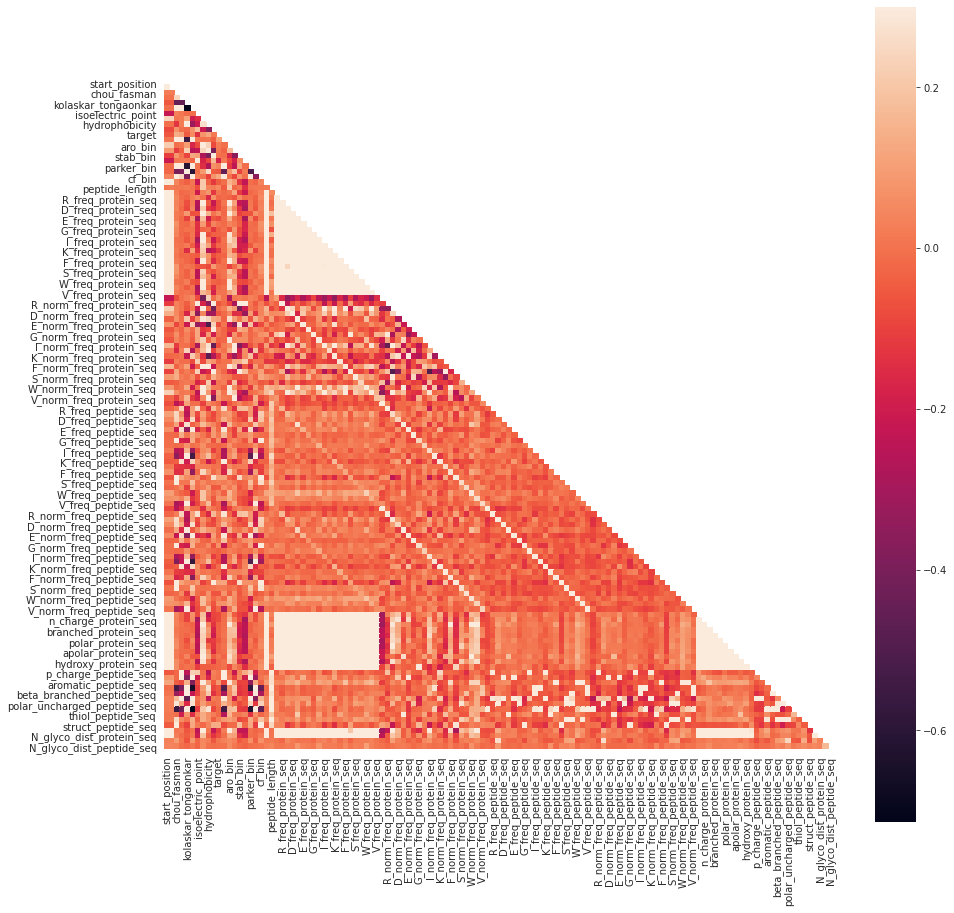

In [22]:
import seaborn as sns 
corr_df = train_modified.filter( [i for i in train_modified.columns if i not in ["protein_seq","parent_protein_id","peptide_seq"] ])
cols = [i for i in corr_df.columns]
sample = corr_df.sample(2000)

corr = np.corrcoef(sample.T)

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 15))

    ax = sns.heatmap(pd.DataFrame(corr,columns = cols, index = cols), mask=mask, vmax=.3, square=True)
    

# Data formatting
We will prepare the data for modelling.<br>
Our approach will consist in training a combined model that will take account of: 
    - Sequences features (peptide features)
    - Metadata features (biochemical features)
    


In [25]:
# Digitize sequences: 
base = {"A":1,"R":16,"N":13,"D":18,"C":3,"E":19,"Q":14,"G":0,"H":17,"I":6,"L":5,
                     "K":15,"M":7,"F":9,"P":4,"S":10,"T":11,"W":8,"Y":12,"V":2}

train_seqs = [[base[k] for k in j] for j in [i for i in train["peptide_seq"]]]
test_seqs = [[base[k] for k in j] for j in [i for i in test["peptide_seq"]]]

# Pad data
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=400)
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=400)

# Store labels 
train_labels = train["target"]
test_labels = test["target"]

# Create metadata sets
train_metadata = train_modified.filter([i for i in train_modified if i not in ["parent_protein_id","protein_seq","peptide_seq"]])
test_metadata = test_modified.filter([i for i in test_modified if i not in ["parent_protein_id","protein_seq","peptide_seq"]])

# Model initialization
We opted for a combined setup with: 
    - Embedding and LSTM layers to learn sequential features 
    - Dense part
These two part are combined and followed by Dense FC layers dropout regularized. 
**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 50)      750000      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 400, 100)     60400       embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 127)]        0                                            
____________________________________________________________________________________________

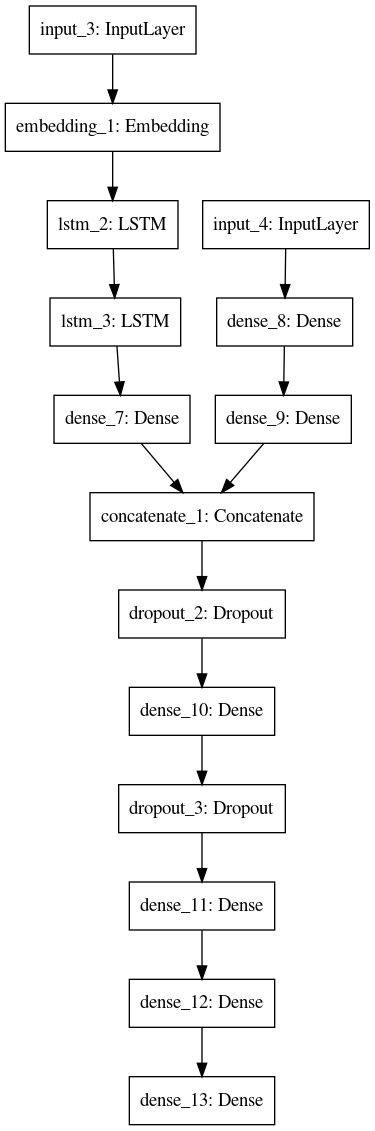

In [31]:

# Sequential part
input_seqs = Input(shape=(train_seqs.shape[1]))
embedding = Embedding(15000, 50, input_length=400)(input_seqs)
LSTM_1 = LSTM(100, return_sequences = True)(embedding)
LSTM_2 = LSTM(70)(LSTM_1)
out_seqs = Dense(50,activation="relu")(LSTM_2)

# Metadata part 
input_metadata = Input(shape=(train_metadata.shape[1]))
D0 = Dense(80,activation="relu")(input_metadata)
D1 = Dense(50,activation="relu")(D0)

# Concatenation 
C1 = concatenate([out_seqs, D1])

# Dense FC with dropout regularization
Dr1 = Dropout(0.1)(C1)
D2 = Dense(50,activation="relu")(Dr1)
Dr2 = Dropout(0.1)(D2)
D3 = Dense(30,activation="relu")(Dr2)
D4 = Dense(10,activation="relu")(D3)
out = Dense(1,activation="sigmoid")(D4)
model = Model(inputs = [input_seqs,input_metadata],outputs=[out])
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='Model_shape.png')

# Training

For training, we will consider an initial training step with a high batch size for few epochs.(2000,20).<br>
This will help the model to learn meta features.<br>

Then, we will fine tune it using a lower a batch size for more epochs.(1000,50).<br>
We will perform another finetuning round with lower BS and more epochs.(500,100).<br>

In addition, we will set weights to the class labels (1/3 imbalancement).<br>

Finally, ROC curves and AUCs will be computed for taining and finetuning.<br>

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 12.5029 - accuracy: 0.2968
Epoch 00001: val_accuracy improved from -inf to 0.73077, saving model to trained.hdf5
8/8 [==============================] - 3s 360ms/step - loss: 12.5029 - accuracy: 0.2968 - val_loss: 2.0094 - val_accuracy: 0.7308
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 2.6217 - accuracy: 0.6269
Epoch 00002: val_accuracy did not improve from 0.73077
8/8 [==============================] - 2s 265ms/step - loss: 2.6217 - accuracy: 0.6269 - val_loss: 1.2890 - val_accuracy: 0.7308
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 2.0416 - accuracy: 0.4386
Epoch 00003: val_accuracy did not improve from 0.73077
8/8 [==============================] - 2s 272ms/step - loss: 2.0416 - accuracy: 0.4386 - val_loss: 0.8858 - val_accuracy: 0.6808
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 1.7091 - accuracy: 0.5317
Epoch 00004: val_accuracy did not improve from 

15/15 [==============================] - ETA: 0s - loss: 0.8966 - accuracy: 0.6766
Epoch 00010: val_accuracy did not improve from 0.62885
15/15 [==============================] - 3s 170ms/step - loss: 0.8966 - accuracy: 0.6766 - val_loss: 1.0952 - val_accuracy: 0.3154
Epoch 11/50
15/15 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.6869
Epoch 00011: val_accuracy did not improve from 0.62885
15/15 [==============================] - 3s 173ms/step - loss: 0.8852 - accuracy: 0.6869 - val_loss: 0.7843 - val_accuracy: 0.3673
Epoch 12/50
15/15 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.6860
Epoch 00012: val_accuracy did not improve from 0.62885
15/15 [==============================] - 3s 176ms/step - loss: 0.8846 - accuracy: 0.6860 - val_loss: 1.0488 - val_accuracy: 0.2788
Epoch 13/50
15/15 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.7053
Epoch 00013: val_accuracy did not improve from 0.62885
15/15 [============

Epoch 39/50
15/15 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8661
Epoch 00039: val_accuracy did not improve from 0.84038
15/15 [==============================] - 3s 171ms/step - loss: 0.4567 - accuracy: 0.8661 - val_loss: 0.4759 - val_accuracy: 0.8327
Epoch 40/50
15/15 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8926
Epoch 00040: val_accuracy improved from 0.84038 to 0.84808, saving model to finetuned_1.hdf5
15/15 [==============================] - 3s 176ms/step - loss: 0.3884 - accuracy: 0.8926 - val_loss: 0.4298 - val_accuracy: 0.8481
Epoch 41/50
15/15 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8891
Epoch 00041: val_accuracy did not improve from 0.84808
15/15 [==============================] - 3s 173ms/step - loss: 0.4018 - accuracy: 0.8891 - val_loss: 0.6006 - val_accuracy: 0.7385
Epoch 42/50
15/15 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.9259
Epoch 00042: val_accurac

Epoch 17/100
29/29 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9704
Epoch 00017: val_accuracy did not improve from 0.97115
29/29 [==============================] - 3s 112ms/step - loss: 0.1306 - accuracy: 0.9704 - val_loss: 0.4104 - val_accuracy: 0.7500
Epoch 18/100
29/29 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9808
Epoch 00018: val_accuracy did not improve from 0.97115
29/29 [==============================] - 3s 113ms/step - loss: 0.0897 - accuracy: 0.9808 - val_loss: 0.1209 - val_accuracy: 0.9673
Epoch 19/100
29/29 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9840
Epoch 00019: val_accuracy improved from 0.97115 to 0.99038, saving model to finetuned_2.hdf5
29/29 [==============================] - 3s 114ms/step - loss: 0.0778 - accuracy: 0.9840 - val_loss: 0.0806 - val_accuracy: 0.9904
Epoch 20/100
29/29 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9751
Epoch 00020: val_acc

Epoch 46/100
29/29 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9838
Epoch 00046: val_accuracy did not improve from 0.99231
29/29 [==============================] - 3s 113ms/step - loss: 0.0626 - accuracy: 0.9838 - val_loss: 0.2452 - val_accuracy: 0.9673
Epoch 47/100
29/29 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9871
Epoch 00047: val_accuracy did not improve from 0.99231
29/29 [==============================] - 3s 115ms/step - loss: 0.0597 - accuracy: 0.9871 - val_loss: 0.4129 - val_accuracy: 0.9346
Epoch 48/100
29/29 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9877
Epoch 00048: val_accuracy did not improve from 0.99231
29/29 [==============================] - 3s 114ms/step - loss: 0.0548 - accuracy: 0.9877 - val_loss: 0.4686 - val_accuracy: 0.9173
Epoch 49/100
29/29 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9899
Epoch 00049: val_accuracy did not improve from 0.99231
29/

29/29 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9967
Epoch 00075: val_accuracy did not improve from 0.99231
29/29 [==============================] - 3s 115ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.3639 - val_accuracy: 0.9788
Epoch 76/100
29/29 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9965
Epoch 00076: val_accuracy did not improve from 0.99231
29/29 [==============================] - 3s 116ms/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.2942 - val_accuracy: 0.9865
Epoch 77/100
29/29 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9935
Epoch 00077: val_accuracy did not improve from 0.99231
29/29 [==============================] - 3s 112ms/step - loss: 0.0321 - accuracy: 0.9935 - val_loss: 0.3909 - val_accuracy: 0.9750
Epoch 78/100
29/29 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9896
Epoch 00078: val_accuracy did not improve from 0.99231
29/29 [=========

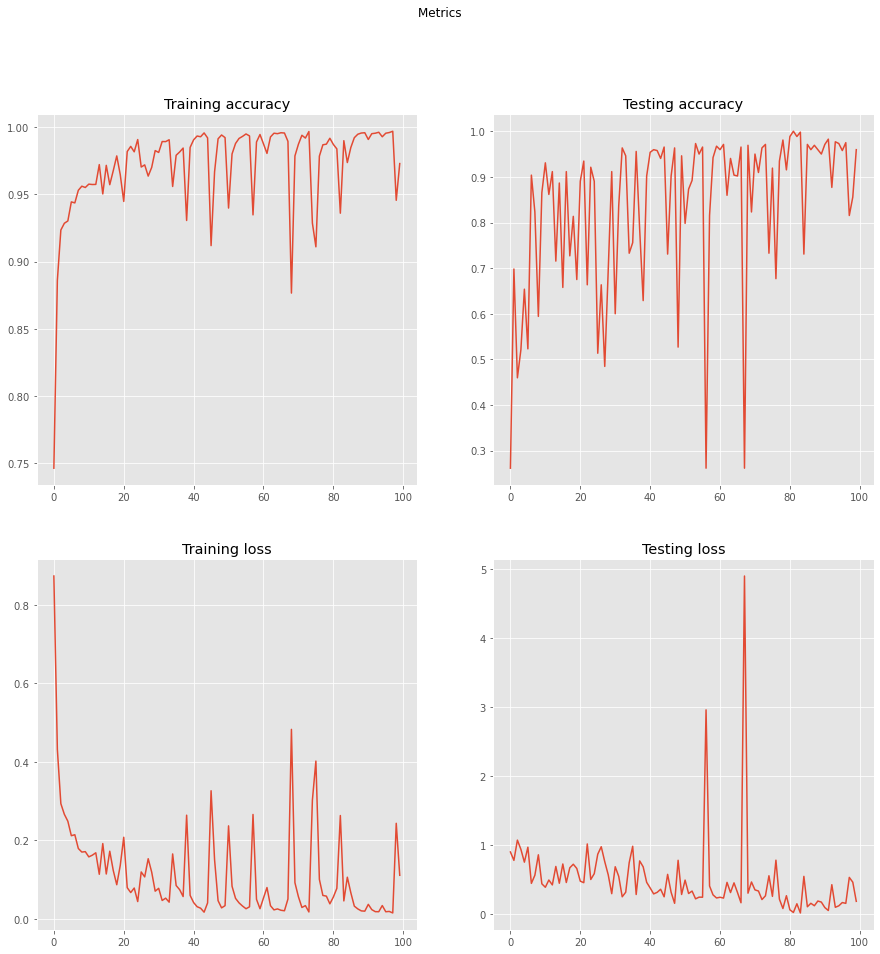

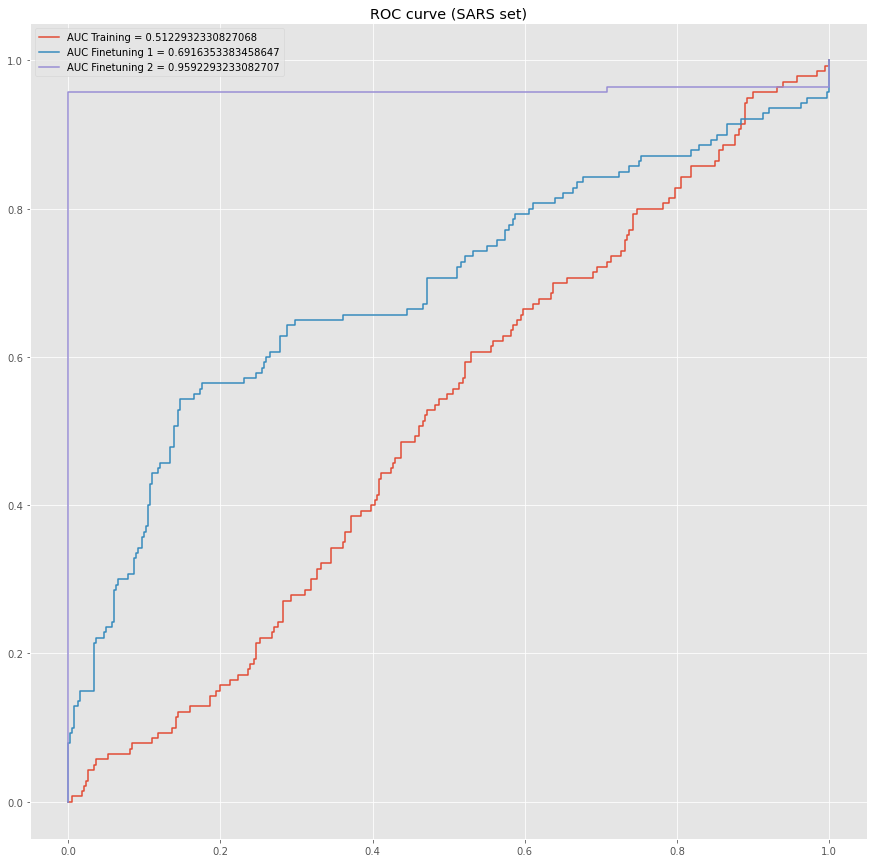

In [32]:
from sklearn.metrics import roc_curve
plt.style.use("ggplot")

# Set class weight
class_weights = {0:1,1:380/140}

# Compîle and set checkpoint
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath = "trained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                                         save_best_only=True, mode='max')
cb = [checkpoint]
# Train
history1 = model.fit([train_seqs,train_metadata], train_labels,validation_data = ([test_seqs,test_metadata],
                    [test_labels]), epochs=20, batch_size=2000,callbacks = cb,class_weight=class_weights)


# Metrics
y_pred_train = model.predict([test_seqs,test_metadata]).ravel()
fpr_0, tpr_0, thresh = roc_curve(test_labels, y_pred_train)
_auc_0 = auc(fpr_0, tpr_0)



# Load model compile and set checkpoiny
model.load_weights(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath = "finetuned_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                                         save_best_only=True, mode='max')
cb = [checkpoint]

# Fine tune 
history2 = model.fit([train_seqs,train_metadata], train_labels,validation_data = ([test_seqs,test_metadata],
                    [test_labels]), epochs=50, batch_size=1000,callbacks = cb,class_weight=class_weights)

# Metrics
y_pred_finetune_1 = model.predict([test_seqs,test_metadata]).ravel()
fpr_1, tpr_1, thresh = roc_curve(test_labels, y_pred_finetune_1)
_auc_1 = auc(fpr_1, tpr_1)


# Load model compile and set checkpoiny
model.load_weights(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath = "finetuned_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                                         save_best_only=True, mode='max')
cb = [checkpoint]

# Finetune 
history3 = model.fit([train_seqs,train_metadata], train_labels,validation_data = ([test_seqs,test_metadata],
                    [test_labels]), epochs=100, batch_size=500,callbacks = cb,class_weight=class_weights)
# Metrics
y_pred_finetune_2 = model.predict([test_seqs,test_metadata]).ravel()
fpr_2, tpr_2, thresh = roc_curve(test_labels, y_pred_finetune_2)
_auc_2 = auc(fpr_2, tpr_2)


# Concatenate histories
accuracy = history1.history["accuracy"]+history2.history["accuracy"]+history3.history["accuracy"]
val_accuracy = history1.history["val_accuracy"]+history2.history["val_accuracy"]+history3.history["val_accuracy"]
loss = history1.history["loss"]+history2.history["loss"]+history3.history["loss"]
val_loss = history1.history["val_loss"]+history2.history["val_loss"]+history3.history["val_loss"]

f = plt.figure(figsize=(15,15))
ax,ax1,ax2,ax3 = f.add_subplot(221),f.add_subplot(222),f.add_subplot(223),f.add_subplot(224)
ax.plot(history.history["accuracy"])
ax1.plot(history.history["val_accuracy"])
ax2.plot(history.history["loss"])
ax3.plot(history.history["val_loss"])

ax.set_title("Training accuracy")
ax1.set_title("Testing accuracy")
ax2.set_title("Training loss")
ax3.set_title("Testing loss")

f.suptitle("Metrics ")
plt.show()

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.plot(fpr_0,tpr_0,label="AUC Training = {}".format(_auc_0))
ax.plot(fpr_1,tpr_1,label="AUC Finetuning 1 = {}".format(_auc_1))
ax.plot(fpr_2,tpr_2,label="AUC Finetuning 2 = {}".format(_auc_2))
ax.set_title('ROC curve (SARS set)')
ax.legend()
plt.show()

# Thanks for your attention